In [165]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
def evaluateSimulation(traj):
    model = search.getModelFromTraj(traj)
    model.randomICs()
    defaultDuration = model.params['duration']
      
    model.params['duration'] = defaultDuration
    
    rect_stimulus = stim.RectifiedInput(amplitude=0.4).to_model(model)
    exc_ext =  model.params['exc_ext']
    #print("e ext, I ext = ", model.params.exc_ext, model.params.inh_ext)
    
    model.params['exc_ext'] = rect_stimulus * 5.0 + exc_ext
    model.run()

    #plt.plot(model.t, model.exc[0,:])
    #plt.show()
    
    state_length = 2000
    down_window = (defaultDuration/2-state_length<model.t) & (model.t<defaultDuration/2)
    up_window = (defaultDuration-state_length<model.t) & (model.t<defaultDuration)
    up_state_rate = np.mean(model.output[:, up_window], axis=1)
    down_state_rate = np.mean(model.output[:, down_window], axis=1)
    up_down_difference = np.max(up_state_rate - down_state_rate)
        
    max_amp_output = np.max(
          np.max(model.output[:, up_window], axis=1) 
        - np.min(model.output[:, up_window], axis=1)
    )
    max_output = np.max(model.output[:, up_window])
     
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output, dt=model.params.dt, maxfr=40, spectrum_windowsize=10)
    max_power = np.max(model_pwrs)     
    
    model_frs, model_pwrs = func.getMeanPowerSpectrum(model.output[:, up_window], dt=model.params.dt, maxfr=40, spectrum_windowsize=5)
    domfr = model_frs[np.argmax(model_pwrs)]    

    result = {
        "end" : 3,
        "max_output": max_output, 
        "max_amp_output" : max_amp_output,
        "max_power" : max_power,
        "domfr" : domfr,
        "up_down_difference" : up_down_difference
    }
    
    search.saveToPypet(result, traj)
    return 

In [98]:
model = WCModel()

model.params['dt'] = 0.1 # Integration time step, ms
model.params['duration'] = 20 * 1000 # Simulation time, ms
model.params['save_dt'] = 10.0 # 10 ms sampling steps for saving data, should be multiple of dt
model.params["exc_ext"] = 0.
model.params["inh_ext"] = 0.

MainProcess root INFO     wc: Model initialized.


In [137]:
from neurolib.optimize.exploration import BoxSearch
from neurolib.utils.parameterSpace import ParameterSpace
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func
import neurolib.optimize.exploration.explorationUtils as eu

parameters = ParameterSpace({"exc_ext": np.linspace(0.0, 4.0, 21), 
                             "inh_ext": np.linspace(0., 3., 16)
                             }, kind="grid")

search = BoxSearch(evalFunction = evaluateSimulation, model=model, parameterSpace=parameters, filename='wc-bifurcation-diagram.hdf')

MainProcess root INFO     Number of processes: 8
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/wc-bifurcation-diagram.hdf`.
MainProcess pypet.environment.Environment INFO     Environment initialized.
MainProcess root INFO     Number of parameter configurations: 336
MainProcess root INFO     BoxSearch: Environment initialized.


In [138]:
search.run()
search.loadResults(all=False)

MainProcess pypet.environment.Environment INFO     I am preparing the Trajectory for the experiment and initialise the store.
MainProcess pypet.environment.Environment INFO     Initialising the storage for the trajectory.
MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-02-13-07H-13M-12S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `results-2023-02-13-07H-13M-12S`.
MainProcess pypet.environment.Environment INFO     
************************************************************
STARTING runs of trajectory
`results-2023-02-13-07H-13M-12S`.
************************************************************

MainProcess pypet.storageservice.HDF5StorageService INFO     Initialising storage or updating meta data of Trajectory `results-2023-02-13-07H-13M-12S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Finished init or meta data update for `resu

In [148]:
search.loadResults(all=False)

MainProcess root INFO     Loading results from ./data/hdf/wc-bifurcation-diagram.hdf
MainProcess root INFO     Analyzing trajectory results-2023-02-13-07H-13M-12S
MainProcess pypet.storageservice.HDF5StorageService INFO     I will use the hdf5 file `./data/hdf/wc-bifurcation-diagram.hdf`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading trajectory `results-2023-02-13-07H-13M-12S`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `config` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `parameters` in mode `2`.
MainProcess pypet.storageservice.HDF5StorageService INFO     Loading branch `results` in mode `1`.
MainProcess root INFO     Creating `dfResults` dataframe ...
MainProcess root INFO     Aggregating results to `dfResults` ...
100%|██████████| 336/336 [00:05<00:00, 61.55it/s]
MainProcess root INFO     All results loaded.


In [162]:
comp_points = [[1., 0.5], [2.8, 1.6], [3., 0.5]]

[1.0, 0.5]
[2.8, 1.6]
[3.0, 0.5]


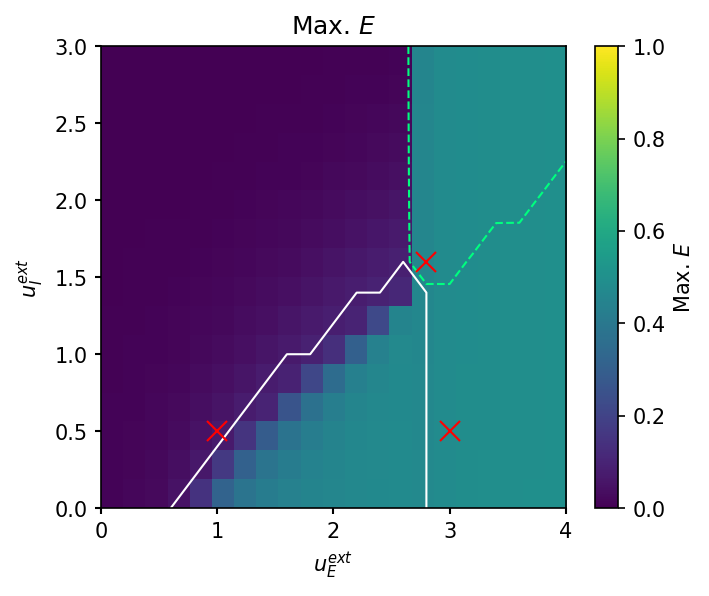

In [163]:
plot_key_label = "Max. $E$"
eu.plotExplorationResults(search.dfResults, 
                          par1=['exc_ext', '$u_E^{ext}$'], 
                          par2=['inh_ext', '$u_I^{ext}$'], 
                          plot_key='max_output',
                          plot_clim=[0.0, 1.0],
                          nan_to_zero=False,
                          plot_key_label=plot_key_label, 
                          one_figure=False,
                          contour=["max_amp_output", "up_down_difference"],
                          contour_color=[['white'], ['springgreen']],
                          contour_levels=[[10], [0.1]],
                          contour_alpha=[1.0, 1.0],
                          contour_kwargs={0 : {"linewidths" : (1,)}, 1 : {"linestyles" : "--", "linewidths" : (1,)}},
                          mask_threshold=0.1,
                          mask_alpha=0.2,
                          points=comp_points,
                          )

MainProcess root INFO     wc: Model initialized.


oscillation period =  15.7


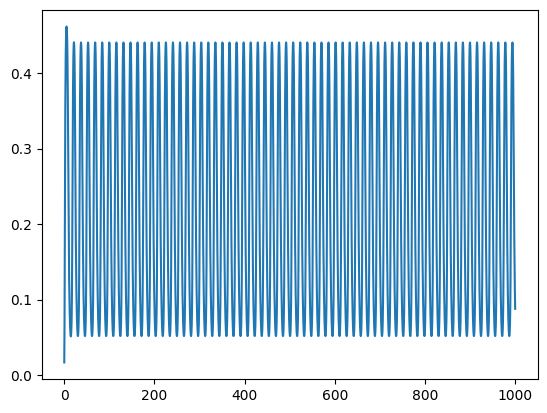

In [168]:
model = WCModel()

model.params['dt'] = 0.1 # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params["exc_ext"] = 2.
model.params["inh_ext"] = 0.5

model.run()
plt.plot(model.t, model.exc[0,:])
peaks = scipy.signal.find_peaks(model.exc[0,100:])[0]
plist = []
for pind in range(1, len(peaks)):
    plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

period = np.around(np.mean(plist),1)
print("oscillation period = ", period)

In [ ]:
duration = 120.
model.params["exc_ext"] = 0.
model.params["inh_ext"] = 0.
controlmat = np.zeros((1,2))
controlmat[0,0] = 1.
model_controlled = oc_wc.OcWc(model, target, print_array=np.arange(0,501,25), control_matrix = controlmat)

# We run 500 iterations of the optimal control gradient descent algorithm
model_controlled.optimize(100)

state = model_controlled.get_xs()
control = model_controlled.control

plot_oc_singlenode(duration, dt, state, target, control, target_input, model_controlled.cost_history)

plt.plot(model_controlled.step_sizes_history)
plt.show()